In [ ]:
import sys
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
file = Path("../stimage").resolve()
parent= file.parent
sys.path.append(str(parent))
from PIL import Image
from stimage._utils import gene_plot, Read10X, ReadOldST, tiling
from stimage._model import CNN_NB_multiple_genes
# from stimage._data_generator import DataGenerator
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Lambda
from tensorflow.keras.models import Model

def CNN_bin_multiple_genes(tile_shape, n_genes, cnnbase="resnet50", ft=False):
    tile_input = Input(shape=tile_shape, name="tile_input")
    if cnnbase == "resnet50":
        cnn_base = ResNet50(input_tensor=tile_input, weights='imagenet', include_top=False)
    elif cnnbase == "vgg16":
        cnn_base = VGG16(input_tensor=tile_input, weights='imagenet', include_top=False)
    elif cnnbase == "inceptionv3":
        cnn_base = InceptionV3(input_tensor=tile_input, weights='imagenet', include_top=False)
    elif cnnbase == "mobilenetv2":
        cnn_base = MobileNetV2(input_tensor=tile_input, weights='imagenet', include_top=False)
    elif cnnbase == "densenet121":
        cnn_base = DenseNet121(input_tensor=tile_input, weights='imagenet', include_top=False)
    elif cnnbase == "xception":
        cnn_base = Xception(input_tensor=tile_input, weights='imagenet', include_top=False)
    #     stage_5_start = resnet_base.get_layer("conv5_block1_1_conv")
    #     for i in range(resnet_base.layers.index(stage_5_start)):
    #         resnet_base.layers[i].trainable = False

    if not ft:
        for i in cnn_base.layers:
            i.trainable = False
    cnn = cnn_base.output
    cnn = GlobalAveragePooling2D()(cnn)
    #     cnn = Dropout(0.5)(cnn)
    #     cnn = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01),
    #                 activity_regularizer=tf.keras.regularizers.l2(0.01))(cnn)
    # cnn = Dense(256, activation='relu')(cnn)
    output_layers = []
    for i in range(n_genes):
        output = Dense(1, activation='sigmoid')(cnn)
        output_layers.append(output)

    model = Model(inputs=tile_input, outputs=output_layers)
    #     losses={}
    #     for i in range(8):
    #         losses["gene_{}".format(i)] = negative_binomial_loss(i)
    #     optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = tf.keras.optimizers.Adam(1e-5)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [ ]:
from typing import Optional, Union
from anndata import AnnData
from PIL import Image
from pathlib import Path
from sklearn.preprocessing import StandardScaler


def low_high_bin(
        adata: AnnData,
        verbose: bool = False,
        copy: bool = False,
) -> Optional[AnnData]:
    scaler = StandardScaler()
    x_z = scaler.fit_transform(adata.to_df())
    x_z[x_z>0] = 1
    x_z[x_z<0] = 0
    adata.X = x_z
    return adata if copy else None

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import KDTree


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, adata, dim=(299, 299), n_channels=3, genes=None, aug=False, tile_path="tile_path"):
        'Initialization'
        self.dim = dim
        self.adata = adata
        self.n_channels = n_channels
        self.genes = genes
        self.num_genes = len(genes)
        self.aug = aug
        self.tile_path = tile_path
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(self.adata.n_obs)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Find list of IDs
        obs_temp = self.adata.obs_names[index]

        # Generate data
        X_img = self._load_img(obs_temp)
        y = self._load_label(obs_temp)

        return X_img, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.adata.n_obs)

    def _load_img(self, obs):
        img_path = self.adata.obs.loc[obs, 'tile_path']
        X_img = image.load_img(img_path, target_size=self.dim)
        X_img = image.img_to_array(X_img).astype('uint8')
        #         X_img = np.expand_dims(X_img, axis=0)
        #         n_rotate = np.random.randint(0, 4)
        #         X_img = np.rot90(X_img, k=n_rotate, axes=(1, 2))
        if self.aug:
            X_img = seq_aug(image=X_img)
#         X_img = preprocess_resnet(X_img)
        return X_img

    def _load_label(self, obs):
        batch_adata = self.adata[obs, self.genes].copy()

        return tuple([batch_adata.to_df()[i].values for i in self.genes])

    def get_classes(self):
        return self.adata.to_df().loc[:, self.genes]
    

import imgaug as ia
from imgaug import augmenters as iaa

ia.seed(3)
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq_aug = iaa.Sequential(
    [
        # apply the following augmenters to most images
        iaa.Fliplr(0.5),  # horizontally flip 50% of all images
        iaa.Flipud(0.5),  # vertically flip 50% of all images
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # scale images to 80-120% of their size, individually per axis
            rotate=(-45, 45),  # rotate by -45 to +45 degrees
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 1),
                   [
                       iaa.OneOf([
                           iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                           #                     iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                           #                     iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                       ]),
                       #                 iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                       #                 iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                       # #                 # search either for all edges or for directed edges,
                       # #                 # blend the result with the original image using a blobby mask
                       #                 iaa.BlendAlphaSimplexNoise(iaa.OneOf([
                       #                     iaa.EdgeDetect(alpha=(0.5, 1.0)),
                       #                     iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                       #                 ])),
                       iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
                       # add gaussian noise to images
                       #                 iaa.OneOf([
                       #                     iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                       #                     iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                       #                 ]),
                       #                 iaa.Invert(0.05, per_channel=True), # invert color channels
                       #                 iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                       iaa.AddToHueAndSaturation((-20, 20)),  # change hue and saturation
                       # #                 # either change the brightness of the whole image (sometimes
                       # #                 # per channel) or change the brightness of subareas
                       #                 iaa.LinearContrast((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                       iaa.Grayscale(alpha=(0.0, 1.0)),
                       #                 sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                       #                 sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                       #                 sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                   ],
                   random_order=True
                   )
    ],
    random_order=True
)


def tf_seq(image, label):
    im_shape = image.shape
    [image, ] = tf.py_function(lambda x: seq_aug(image=x), [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label



In [ ]:
BASE_PATH = Path("/home/uqxtan9/Q1851/Xiao/STimage_dataset/breast_cancer_10x_visium")
TILE_PATH = Path("/tmp") / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)

SAMPLE = "block1"
Sample1 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif", 0)
Sample1.uns["spatial"][SAMPLE]['images']["fulres"] = img

SAMPLE = "block2"
Sample2 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_2_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_2_image.tif", 0)
Sample2.uns["spatial"][SAMPLE]['images']["fulres"] = img

In [ ]:
gene_list=["SLITRK6", "PGM5", "LINC00645", 
           "TTLL12", "COX6C", "CPB1",
           "KRT5", "MALAT1", "CD74"]
gene_list

In [ ]:
for adata in [
    Sample1,
    Sample2,
]:
#     count_df = adata.to_df()
#     count_df[count_df <=1] = 0
#     count_df[count_df >1] = 1
#     adata.X = count_df
#     adata[:,gene_list]
    st.pp.filter_genes(adata,min_cells=3)
#     st.pp.normalize_total(adata)
    st.pp.log1p(adata)
#     st.pp.scale(adata)
    low_high_bin(adata)
    # pre-processing for spot image
    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    tiling(adata, TILE_PATH_, crop_size=299)

In [ ]:
for i in gene_list:
    print(i)
    gene_plot(Sample1, genes=i, spot_size=8)

In [ ]:
n_genes = len(gene_list)
# training_index = Sample1.obs.sample(frac=0.7, random_state=1).index
# training_dataset = Sample1[training_index,].copy()

# valid_index = Sample1.obs.index.isin(training_index)
# valid_dataset = Sample1[~valid_index,].copy()

training_index = Sample1.obs.sample(frac=0.7, random_state=1).index
training_dataset = Sample1.copy()

valid_index = Sample1.obs.index.isin(training_index)
valid_dataset = Sample1[~valid_index,].copy()

test_dataset = Sample2.copy()

train_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=training_dataset, 
                          genes=gene_list, aug=False),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=valid_dataset, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen_ = test_gen.batch(1)

In [ ]:
model = CNN_bin_multiple_genes((299, 299, 3), n_genes)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                            restore_best_weights=False)

In [ ]:
train_history = model.fit(train_gen_,
                          epochs=100,
                          validation_data=valid_gen_,
                          callbacks=[callback]
                          )

In [ ]:
test_predictions = model.predict(test_gen_)
test_dataset.obsm["predicted_gene"] = np.squeeze(np.array(test_predictions)).transpose()

In [ ]:
model.save("./CNN_bin_9genes_model.h5")

In [ ]:
test_dataset_ = test_dataset[:,gene_list].copy()
test_dataset_.X = test_dataset_.obsm["predicted_gene"]

In [ ]:
for i in gene_list:
    print(i)
    gene_plot(test_dataset_, genes=i, spot_size=8)

In [ ]:
def model_predict_gene(gene):
    i = gene_list.index(gene)
    def model_predict(x):
        test_predictions = model.predict(x)     
        y_pred = np.squeeze(np.array(test_predictions))[i]
        return y_pred.reshape(-1,1)
    return model_predict

In [ ]:
from lime import lime_image

In [ ]:
import skimage
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
import scipy as sp
from scipy import ndimage as ndi
from skimage.morphology import area_opening
import math
from sklearn.linear_model import LinearRegression, SGDRegressor

In [ ]:
# for image, label_ in test_gen.shuffle(200).take(1):
#     annotation_hed = rgb2hed(image)
#     annotation_h = annotation_hed[:,:,0]
#     annotation_h *= 255.0 / np.percentile(annotation_h, q=90)
# #     annotation_h = np.clip(annotation_h, a_min=0, a_max=255)
#     thresh = skimage.filters.threshold_otsu(annotation_h)
#     im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
#         annotation_h < thresh
#     )
#     distance = ndi.distance_transform_edt(im_fgnd_mask)
#     coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
#     mask = np.zeros(distance.shape, dtype=bool)
#     mask[tuple(coords.T)] = True
#     markers, _ = ndi.label(mask)
#     labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
#     im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
#     map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
#     im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    
#     fig = plt.figure()
#     plt.subplot(2, 2, 1)
#     plt.imshow(image.numpy().astype(int))
#     plt.subplot(2, 2, 2)
#     plt.imshow(im_fgnd_mask)
#     plt.subplot(2, 2, 3)
#     plt.imshow(annotation_h,cmap="gray")
#     plt.subplot(2, 2, 4)
#     plt.imshow(image.numpy().astype(int))
#     plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask,
#                                        im_fgnd_mask, 
#                                        bg_label=0),
#                alpha=im_fgnd_mask,
#                origin='upper')
#     plt.show()

In [ ]:
def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=80)
#     annotation_h = np.clip(annotation_h, a_min=0, a_max=255)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask



In [ ]:
def LIME_plot(image, label_, gene1, model_predict_gene, gene_list):
    gene_i = gene_list.index(gene1)
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image.numpy().astype("double"), 
                                             model_predict_gene(gene1), 
                                             top_labels=1, num_samples=1000,
                                             hide_color=0,
#                                              num_features=10000,
#                                              model_regressor=SGDRegressor(),
                                             segmentation_fn=watershed_segment)
    dict_heatmap1 = dict(explanation.local_exp[explanation.top_labels[0]])
    heatmap1 = np.vectorize(dict_heatmap1.get)(explanation.segments)
    prediction = model_predict_gene(gene1)(np.expand_dims(image.numpy(), 0)).ravel()
    print("{}:".format(gene1))
    print("prediction: " + str(prediction))
    print("ground truth: " + str(label_[gene_i].numpy().ravel()))
    fig = plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().astype(int))
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap1, alpha=1, cmap = 'RdYlBu_r', vmax=1, vmin=-1)
    plt.subplot(1, 3, 3)
    plt.imshow(image.numpy().astype(int))
    plt.imshow(heatmap1, alpha=0.3, cmap = 'RdYlBu_r', vmax=1, vmin=-1)
    plt.tight_layout()
    plt.show()

2021-08-18 17:17:47.160747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1246 of 2000
2021-08-18 17:17:53.303335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
/scratch/tmp/pbs.282809.delta2/ipykernel_20580/3873030898.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)


  0%|          | 0/1000 [00:00<?, ?it/s]

COX6C:
prediction: [0.54285663]
ground truth: [1.]


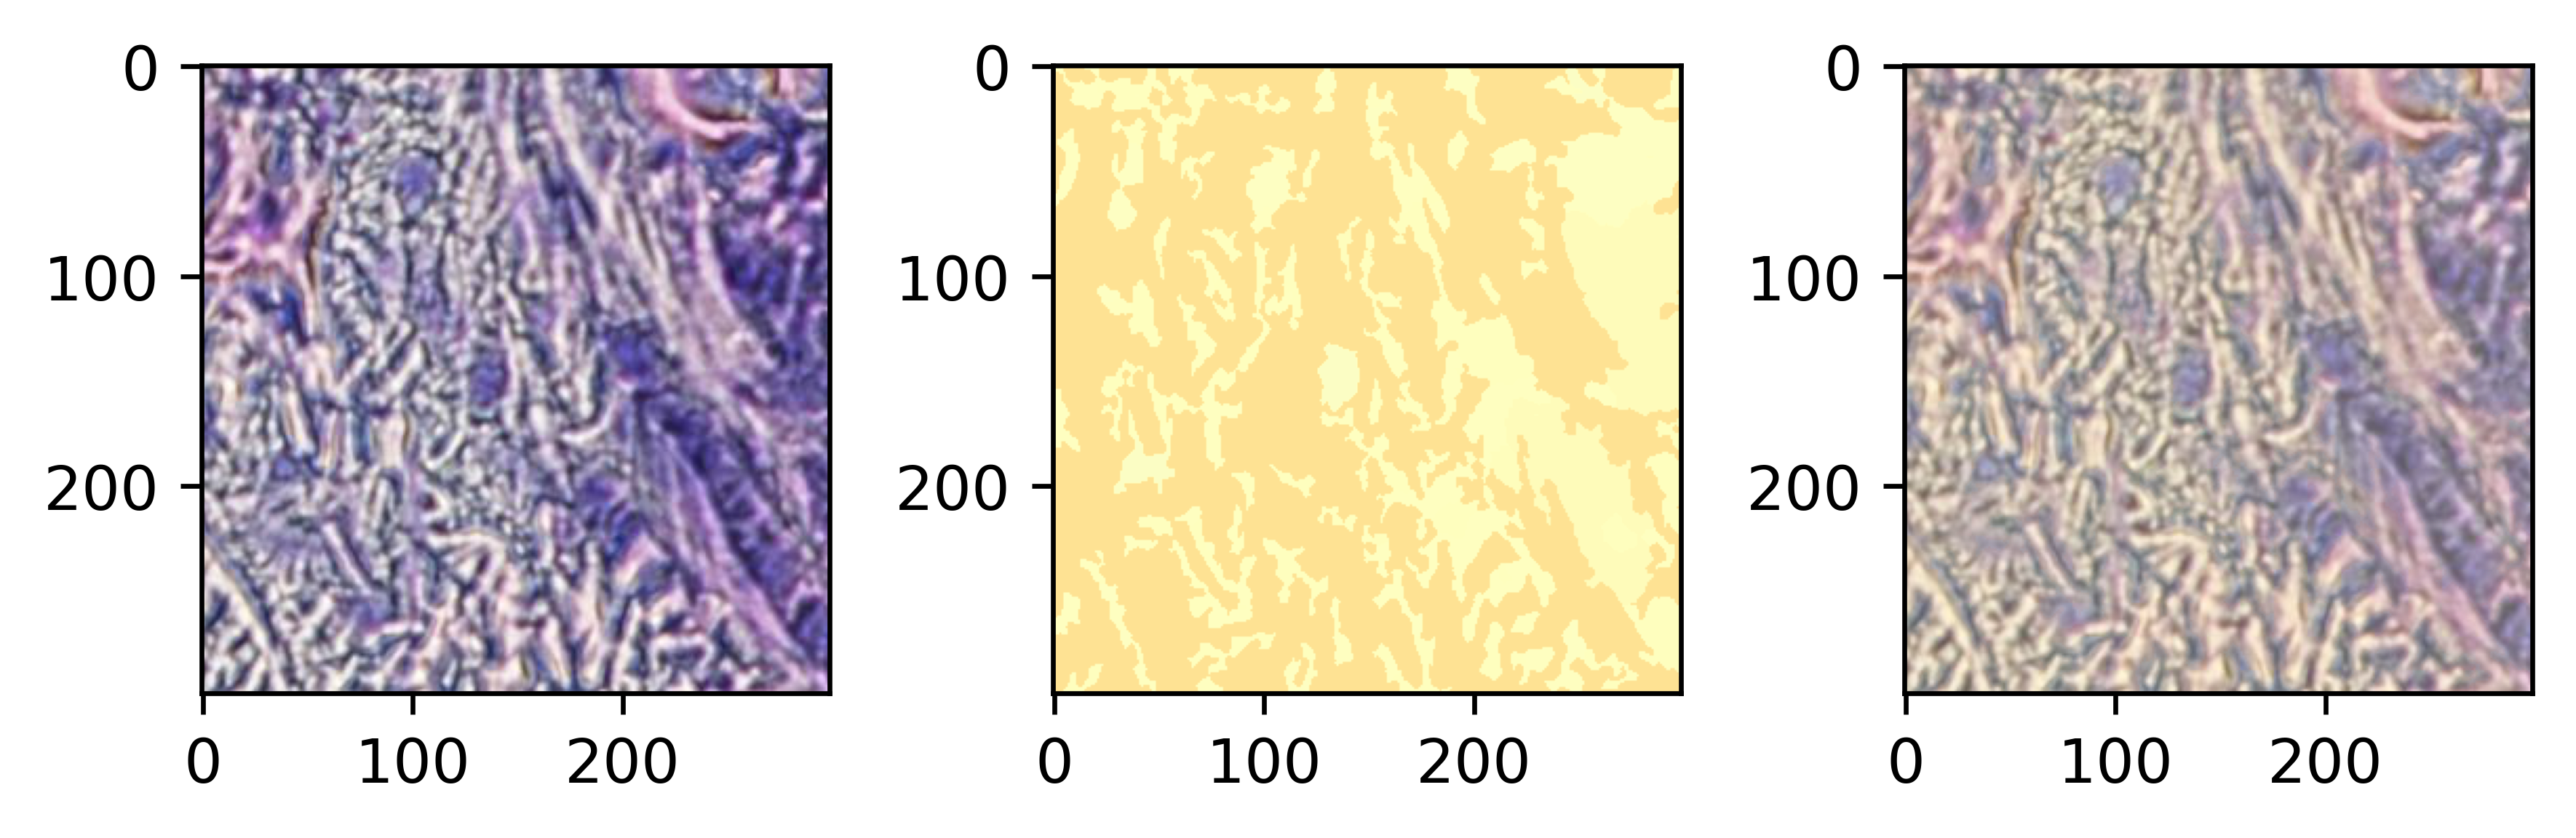

/scratch/tmp/pbs.282809.delta2/ipykernel_20580/3873030898.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
for image_, label_ in test_gen.shuffle(2000).take(1):
    LIME_plot(image_, label_, "COX6C", model_predict_gene, gene_list)
    LIME_plot(image_, label_, "CD74", model_predict_gene, gene_list)

2021-08-18 17:15:43.292898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1169 of 2000
2021-08-18 17:15:49.942078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.
/scratch/tmp/pbs.282809.delta2/ipykernel_20580/3873030898.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)


  0%|          | 0/1000 [00:00<?, ?it/s]

COX6C:
prediction: [0.63852525]
ground truth: [1.]


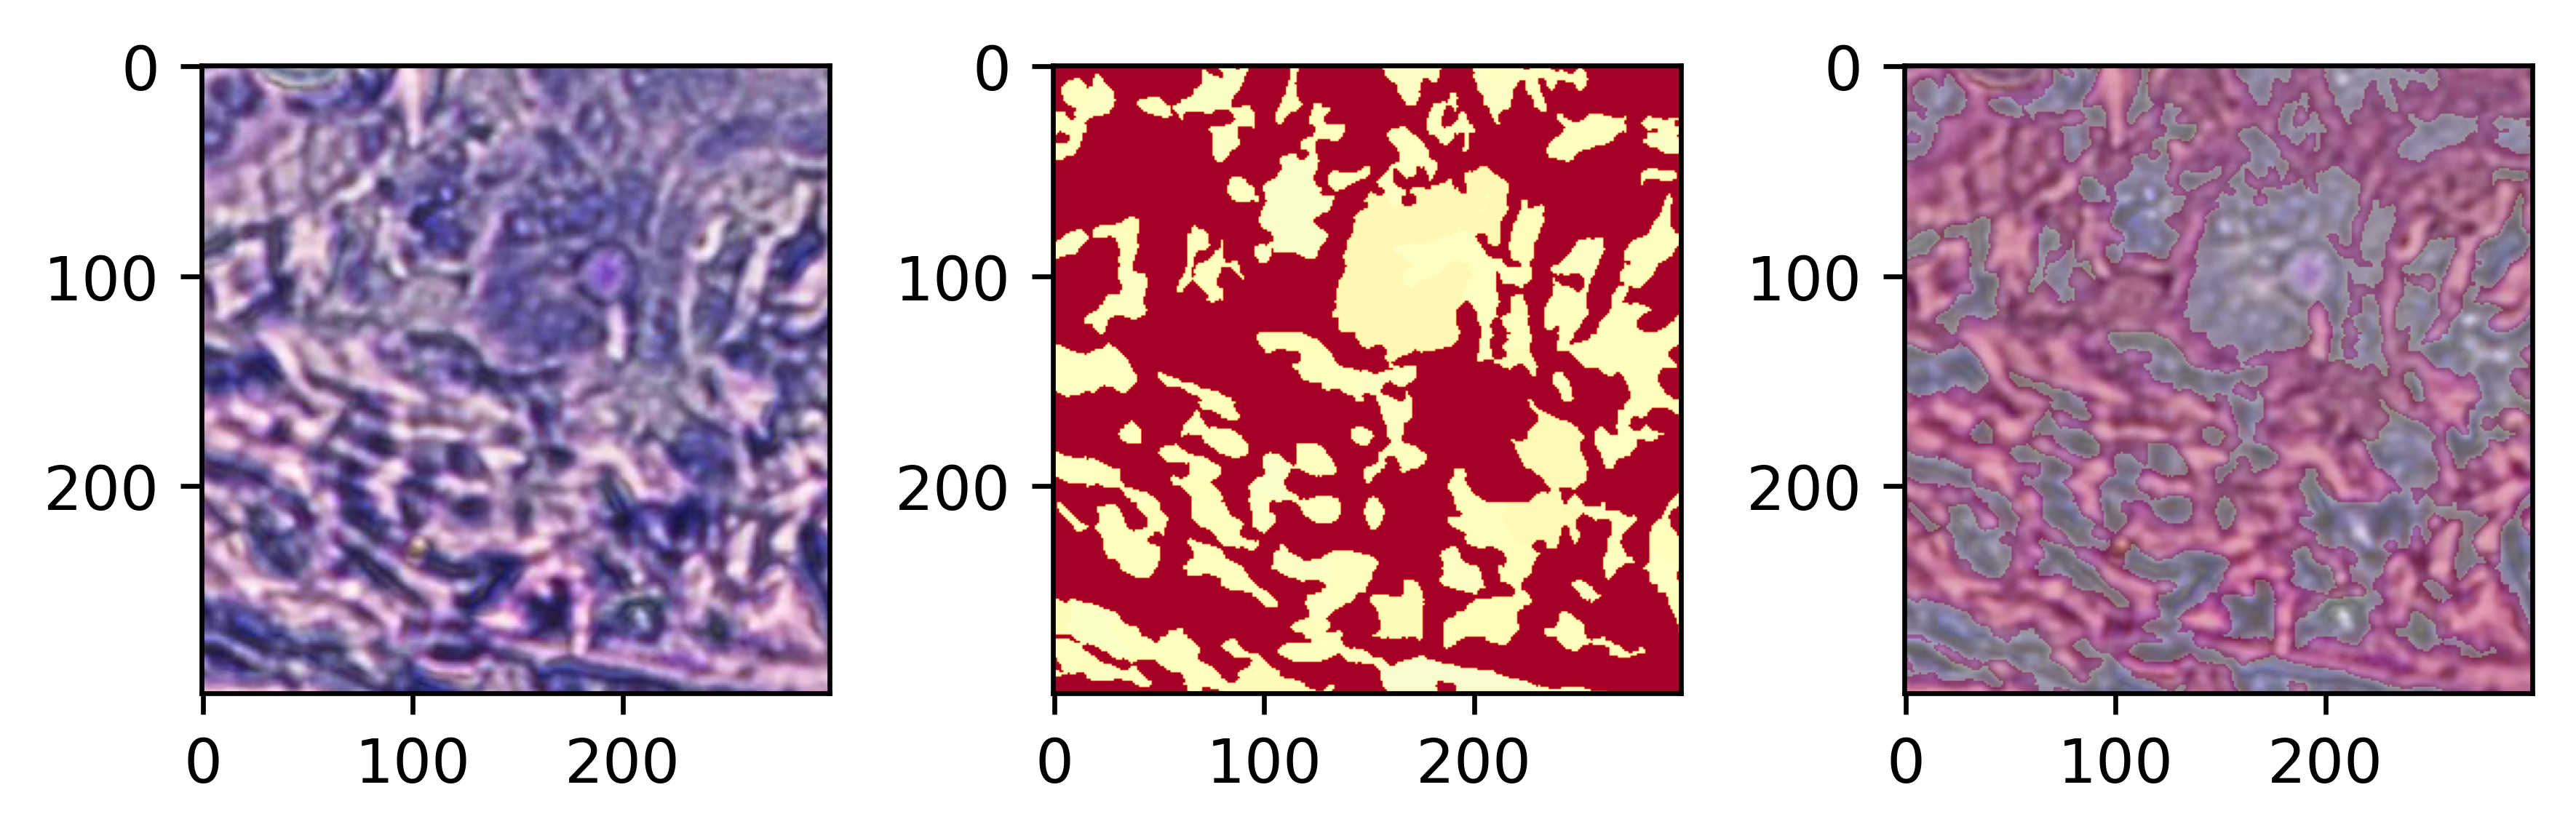

/scratch/tmp/pbs.282809.delta2/ipykernel_20580/3873030898.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)


  0%|          | 0/1000 [00:00<?, ?it/s]

CD74:
prediction: [0.5338218]
ground truth: [0.]


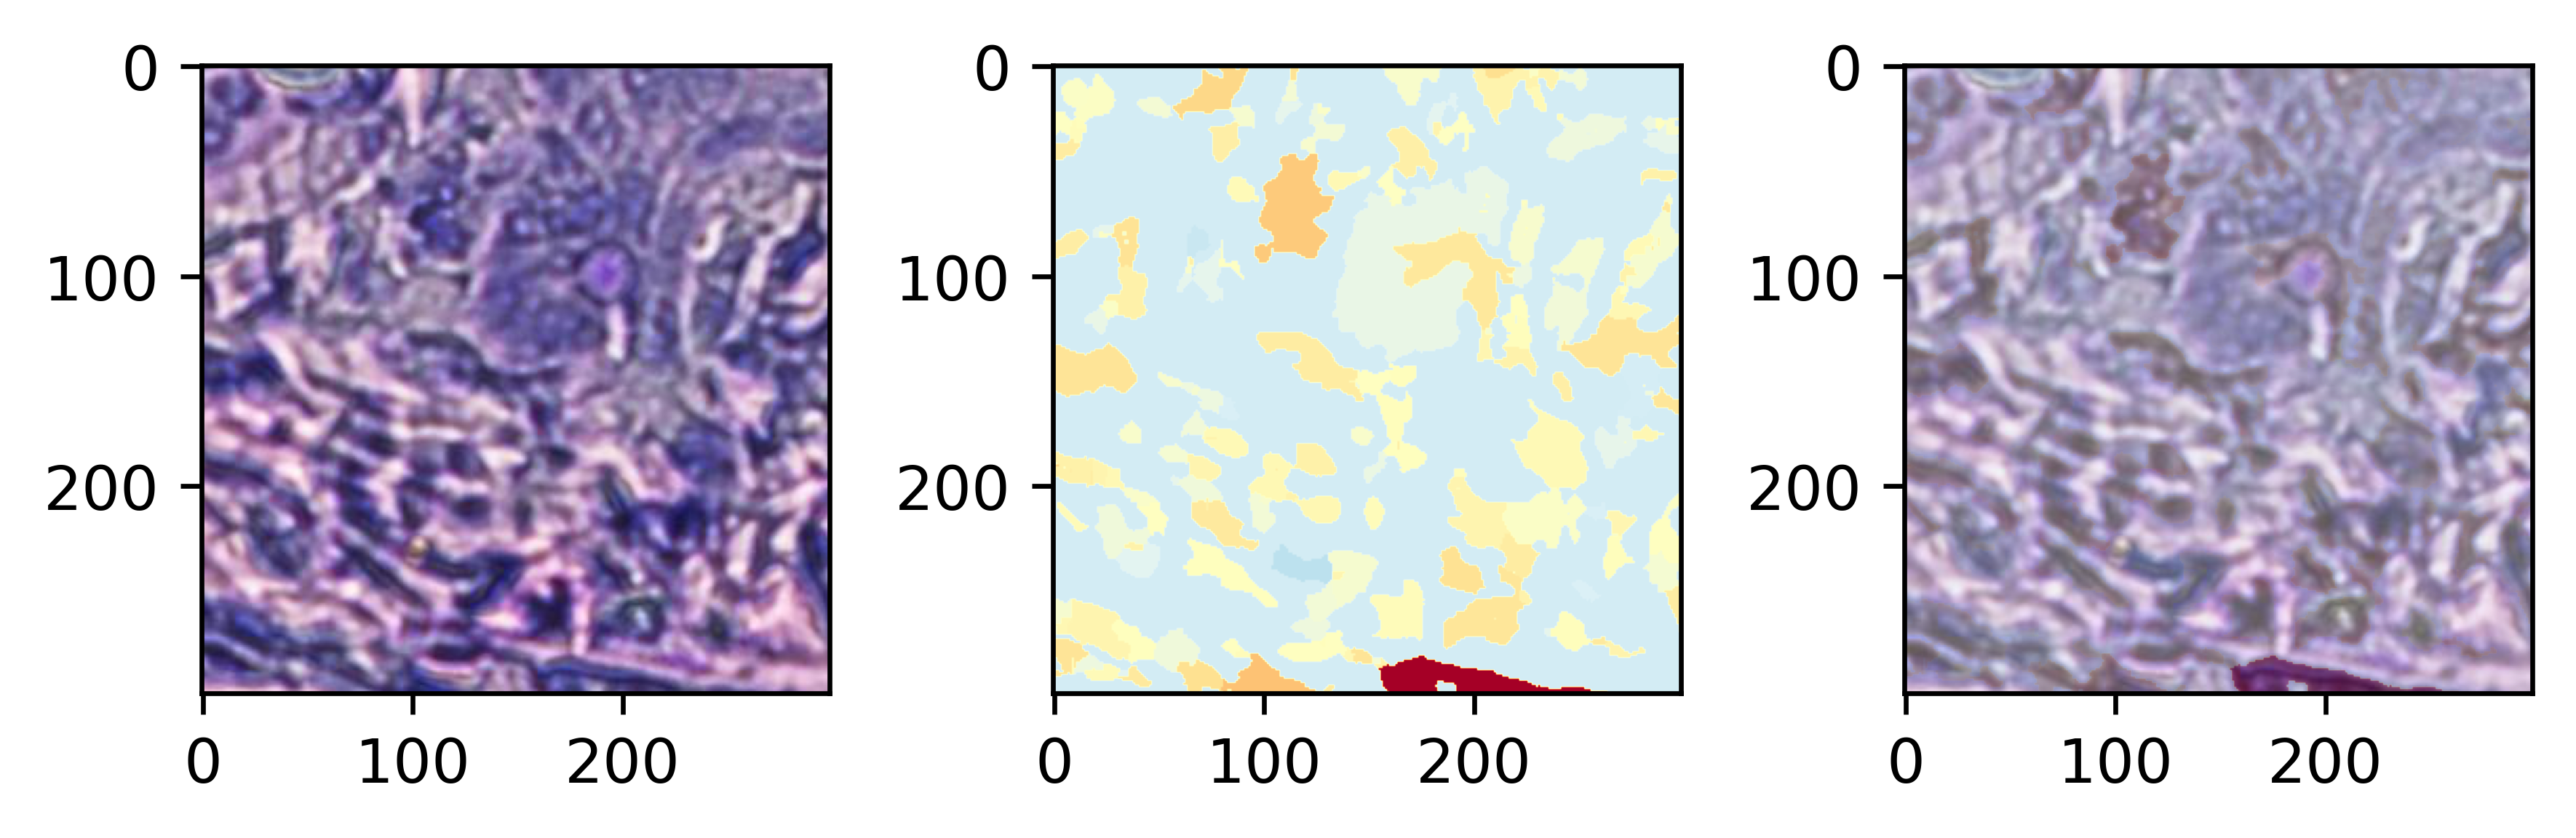

In [117]:
for image_, label_ in test_gen.shuffle(2000).take(1):
    LIME_plot(image_, label_, "COX6C", model_predict_gene, gene_list)
    LIME_plot(image_, label_, "CD74", model_predict_gene, gene_list)